# Chapter 8 컨볼루션을 활용한 일반화

### import

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from matplotlib import pyplot as plt
import datetime
import torch.nn.functional as F

### 필요한 데이터 불러오기

In [ ]:
data_path = '../data-unversioned/plch8/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor())

### 새와 비행기 관련 데이터 만들기

In [ ]:
x = [x for x in [0,2]]
print(x)

In [ ]:
label_map = {0:0, 2:1} # 원본에서 0이 비행기이고 ,2가 새다.

class_names = ['airplane','bird']

cifar2 = [ (img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [ (img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

### 데이터 합친 코드

In [ ]:
data_path = '../data-unversioned/plch8/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,transform=transforms.ToTensor())


label_map = {0:0, 2:1} # 원본에서 0이 비행기이고 ,2가 새다.

class_names = ['airplane','bird']

cifar2 = [ (img, label_map[label]) for img, label in cifar10 if label in [0,2]]

#  if label in [0,2] -> label이 0 또는 2 중 하나일 때 True가 되는 조건이다.
cifar2_val = [ (img, label_map[label]) for img, label in cifar10_val if label in [0,2]]

## 8.1 컨볼루션

- 하늘을 나는 비행기 같은 물체와 일치하는 패턴을 인지하려면 인근 픽셀의 배열 방식을 살펴봐야하고, 서로 멀리 떨어져있는 픽셀들에는 관심을 덜 가져도 된다.
- 이미지의 내의 다른 픽셀이 아닌 바로 옆 픽셀에 대한 가중치의 합을 계산하면 된다.
- 센터가 되는 픽셀에서 일정 거리 떨어진 경우 가중치가 0이 된다고 생각하면 된다.

### 8.1.1 Convolution의 역할

### 평행이동 불변성
-  지역화된 패턴이 이미지의 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질


- 입력에 대해 상대적으로 같은 위치에 있는 엔트리가 출력 픽셀에 동일한 영향을 줄 방법을 찾아야한다.
같은 값으로 초기화해야하며, 그래서 이 경우와 관련된 가중치가 훈련을 통해 업데이트 시 영향을 받지 않아야한다

1. 같은 위치의 엔트리가 동일한 영향을 주려면?
    - 이미지의 (x,y) 위치에 있는 픽셀이 출력의 (x,y)위치에 항상 같은 방식으로 영향을 주게 하려면 , 해당 위치에 적용되는 가중치가 모든 입력에 대해 동일해야한다.
    - (x,y) 위치에 있는 입력이 (x,y) 위치의 출력에 미치는 영향이 항상 같으려면 , 가중치가 위치에 따라 다르지 않고 동일하게 적용되어야한다.
    - 완전 연결층(Linear)는 각 위치마다 가중치가 다르기 때문에, 같은 모양이 다른 위치에 있으면 다른 결과가 나왔다.
    - CNN은 하나의 필터(가중치 집합)을 이미지 전체에 슬라이딩해서 적용하므로 같은 패턴이 어디에 있든 동일한 방식으로 인식할 수 있다.

2. 같은 값으로 초기화해야하는 이유
    - 모든 위치에 같은 영향을 주고 싶다면, 초기 가중치도 동일하게 설정해야한다.
    - 모든 가중치를  같은 값으로 초기화하면 신경망의 각 뉴런이 똑같이 업데이트되어 학습이 제대로 되지 않는 문제가 생긴다.
    - 그래서 작은 랜덤값이나 입력/출력 특성에 맞는 분포로 초기화해서 각 뉴런이 다르게 학습할 수 있도록 한다.

3. 이 경우와 관련된 가중치가 훈련을 통해 업데이트 시 영향을 받지 않아야한다.
    - 만약 어떤 가중치가 항상 같은 값으로 초기화되고, 학습 중에도 업데이트되지 않든ㄴ다면 그 가중치는 출력에 항상 같은 영향만 주고 학습을 통해 변화하지 않게 된다.

---

- 이미지에 대한 지역적인, 평행이동 불변성을 보장하는 선형 연산 : 이겝 바로 컨볼루션이다

- 이산 컨볼루션 discrete convolution
    - 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것으로 정의
    - 가중치 행렬은 커널이라 부르며, 입력의 모든 이웃에 대해 수행한다.
    

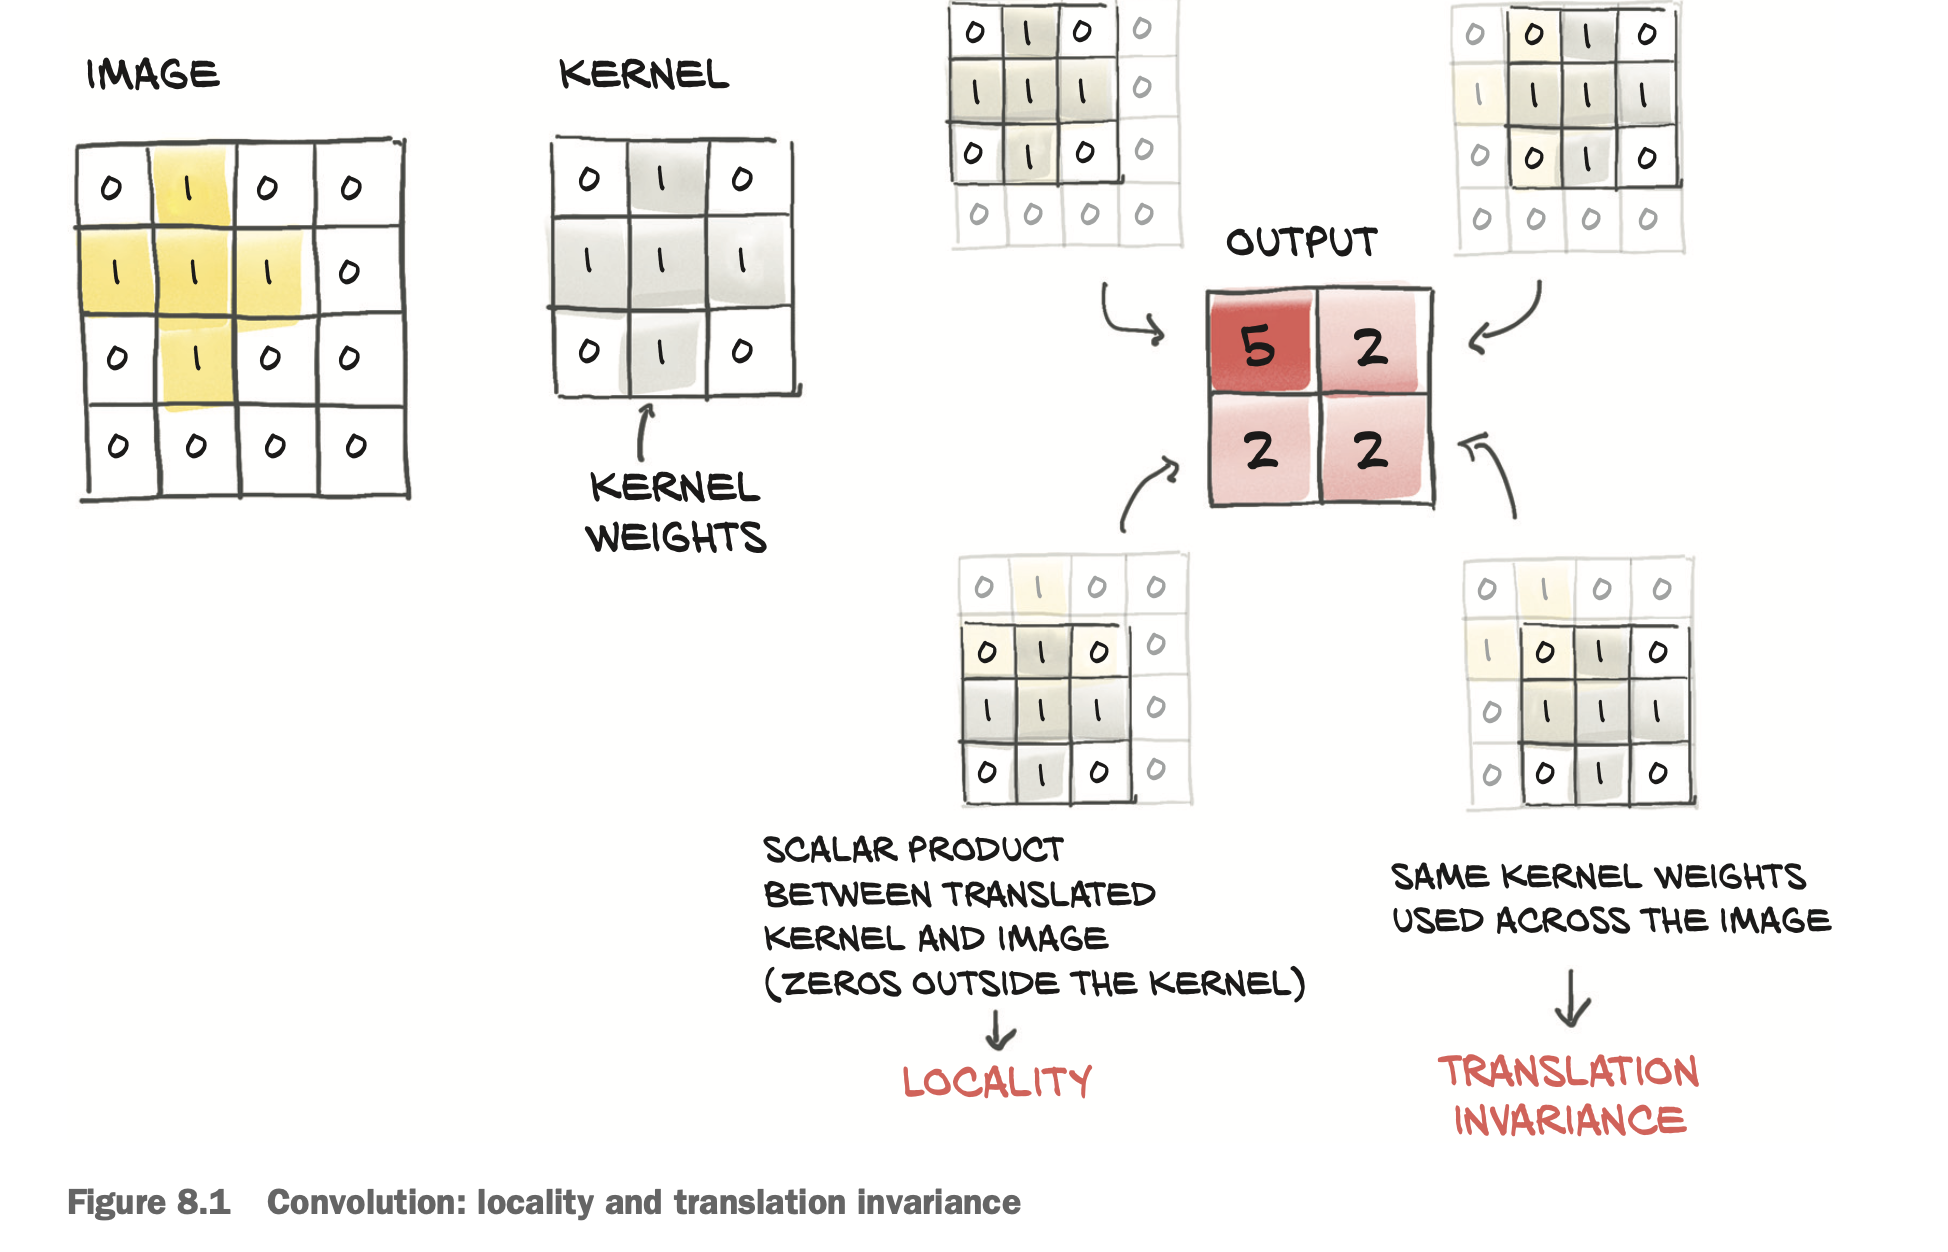

- 위와 같은 방식으로 입력의 모든 위치에 대해 커널을 이동시켜 가변서 가중치의 합을 구해 출력이미지를 만들었다.
- 커널의 가중치는 미리 알 수 없다. 랜덤으로 초기화되고 역전파를 통해 업데이트된다.
- 동일한 커널의 각 가중치가 전체 이미지에 대해 계속 사용된다.
- 컨볼루션 가중치에 대한 손실값의 미분은 이미지 전체가 기여한다
    - CNN에서 하나의 컨볼루션 필터(가중치 집합)가 이미지 전체를 슬라이딩하여 적용되기 때문에 손실함수의 미분을 계산할 때 이미지의 모든 위치가 해당 가중치에 영향을 준다.

---

- 컨볼루션은 어떤 한 픽셀 주의를 제외한 나머지 가중치를 0으로 하는 여러 개의 선형 연산이며 훈련 중에 각각으로부터 동일한 업데이트를 받는다.
    - 전체 이미지를 한번에 곱하는게 아니라 각 출력 픽셀을 계산할 때 해당 픽셀 주변(커널영역)에만 가중치를 곱하고 나머지 입력 픽셀에는 가중치가 0이 곱해진 것과 같은 효과


- 컨볼루션을 사용하면
    - 주위 영역에 대한 지역 연산 가능
    - 평행 이동 불변성
    - 더 적은 파라미터 사용 가능

# 8.2 컨볼루션 사용해보기

In [ ]:
# 파이토치에서 컨볼루션 사용해보기
'''
nn.Conv1d - 시계열
nn.Conv2d - 이미지
nn.Conv3d - 용적 데이터나 동영상

새와 비행기 CIFAR-10 은 nn.Conv2d를 사용
- 최소 입력 피처 수 (멀티 채널의 경우 채널 정보) -> 우리는 RGB니까 3
- 출력 피처 수 -> 임의로 16
- 커널의 크기 -> 임의로 3*3
'''

conv = nn.Conv2d(3,16,kernel_size = 3)
conv

#### Weight 텐서는 어떤 차원 정보를 가질까?

- the shape of the weight tensor?
- 커널은 3*3 이므로 가중치 역시 3*3 을 사용한다.
1. 입력 채널(in_ch)과 커널 크기(3*3)
    - 컬러 이미지라면 입력 채널 수(in_ch)는 3
    - 커널(필터) 하나는 3*3 크기
    - 하나의 출력 픽셀을 계산할 때, 각 입력 채널마다 3*3 영역에 가중치가 적용된다.
    - 그래서 한개의 출력 픽셀을 위한 가중치 shape는 (in_ch, 3,3) 이다.
2. 출력 채널(out_ch)의 수
    - CNN에서는 여러 개의 필터(커널)을 사용해서 다양한 특징을 추출한다.
    - 필터의 개수 = 출력 채널 수(out_ch)
    - 각 출력 채널마다 (in_ch, 3,3)크기의 가중치 집합이 필요하다.
3. 전체 가중치 텐서의 shape
    - 전체 weight tensor의 shape는 (out_ch, in_ch, 3,3)
    - 즉 16개의 필터 각각이 3채널 입력에 대해 3*3 커널을 갖는 구조

- 편향값의 크기는 각 채널에 더하는 상수 ->  16이다.


In [ ]:
conv.weight.shape, conv.bias.shape

- 이제 전체 이미지를 돌며 해당 가중치를 최적화하기 위해 부분 패턴을 찾는 훨씬 더 작은 모델을 만들었다.

- 2차원 컨볼루션 전달(pass)은 2차원 이미지를 출력한다.
- 여기서 출력 픽셀은 입력 이미지의 각 이웃 데이터에 대한 가중치의 합이다.   
- A 2D `**convolution pass**` produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image.

- 여기서 convolution pass는 컨볼루션 레이어가 입력 이미지를 한번 전체적으로 처리해서 출력이미지를 만드는 연산(한번에 forward 연산)
    - 2D convolution pass는 입력 이미지를 커널(필터)로 슬라이딩하면서 각 위치마다 "주변 픽셀들의 가중치합"을 계산해서 새로운 출력 픽셀을 만든다.
    - 이 과정을 이미지 전체에 반복해서, 입력 이미지 -> 출력 이미지(feature map)으로 변환하는 한번의 연산을 convolution pass라고 부른다.

- 여기서 출력 픽셀은 입력 이미지의 각 이웃 데이터에 대한 가중치의 합이다.
    - 우리의 경우 커널 가중치와 편향값 cov.weight가 랜덤으로 초기화된다.

- 하나의 입력 이미지로 conv 모듈을 호출하려면 nn.Conv2d는 입력으로 B * C * H * W를 받으므로 통상 0번째 차원을 unsqueeze를 통해 배치 차원으로 사용한다.

- As usual, we need to add the zeroth batch dimension with
unsqueeze if we want to call the conv module with one input image, since nn.Conv2d
expects a B × C × H × W shaped tensor as input:

    - 이미지가 (C, H, W) 형태라면 이 이미지 1장만 처리할 때에도 (1,C,H,W)처럼 배치 차원을 추가해야한다는 의미이다!!

    - 신경망은 한번에 여러 이미지를 처리할 수 있도록 설계되어있기 때문


In [ ]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))

img.shape, img.unsqueeze(0).shape, output.shape

In [ ]:
plt.imshow(img.permute(1,2,0), cmap='gray')
#plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [ ]:
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

- 오잉 근데 output의 크기가 torch.Size([1,16,30,30])이다.
- 픽셀이 조금 잘렸다.!!!!
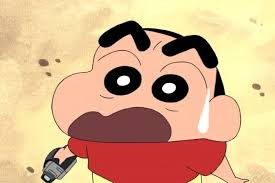

### 8.2.1 경계 패딩하기

#### 각 차원에서 두 픽셀만큼 없어진 이유 알아보기

- 출력이미지가 입력 이미지보다 작은 것은 이미지의 경계에서 이뤄지는 작업에 따른 side effect 부작용이다.

- 3*3 이웃 영역에 컨볼루션 커널을 가중치 합으로 적용하려면 모든 방향에 값이 있어야한다.
    1. 커널(필터)은 3*3 크기의 작은 행렬
    2. 입력 이미지의 한 위치에 적용
        - 입력 이미지에서 한 픽셀을 중심으로 주변 3*3 영역을 선택
        - 이 3*3 영역의 각 픽셀과 커널의 각 가중치를 같은 위치끼리 곱해서 모두 더한다(weight sum)
    3. 출력 픽셀 생성
        - 이렇게 계산된 값이 출력 이미지의 해당 위치 픽셀 값이 된다.
- 수평과 수직 위치는 `width - kernel_width +1`로 구한다.
    - 출력 이미지 feature map의 가로 세로 크기 계산
    - 입력 이미지의 가로 길이 : width
    - 커널(필터)의 가로 길이 : kernal_width
    - 커널을 이미지의 왼쪽에서 오른쪽으로 한칸씩 이동시키며 적용할 수 있는 위치의 개수를 구하는 공식이 width - kernel_width +1이다.
    - 세로 방향(높이) : height - kernel_height + 1
- 홀수의 경우 컨볼루션 커널의 길이의 절반만큼 양쪽 그림이 잘린다
    - ex : 입력 7, 커널 3 -> 출력 (7 - 3 +1) 5
    - 양쪽에서 1픽셀씩 잘린다.
    - 홀수 크기 커널은 중심이 정확히 한 가운데 있음
    - 그래서 커널의 중심이 이미지의 맨 처음/끝에 오도록 하려면 커널의 절반만큼 양쪽이 잘려서 출력이 작아진다.

---
- 파이토치에서는 이미지 경계에 값이 0인 가짜(ghost) 픽셀을 패딩해주는 기능을 제공한다.
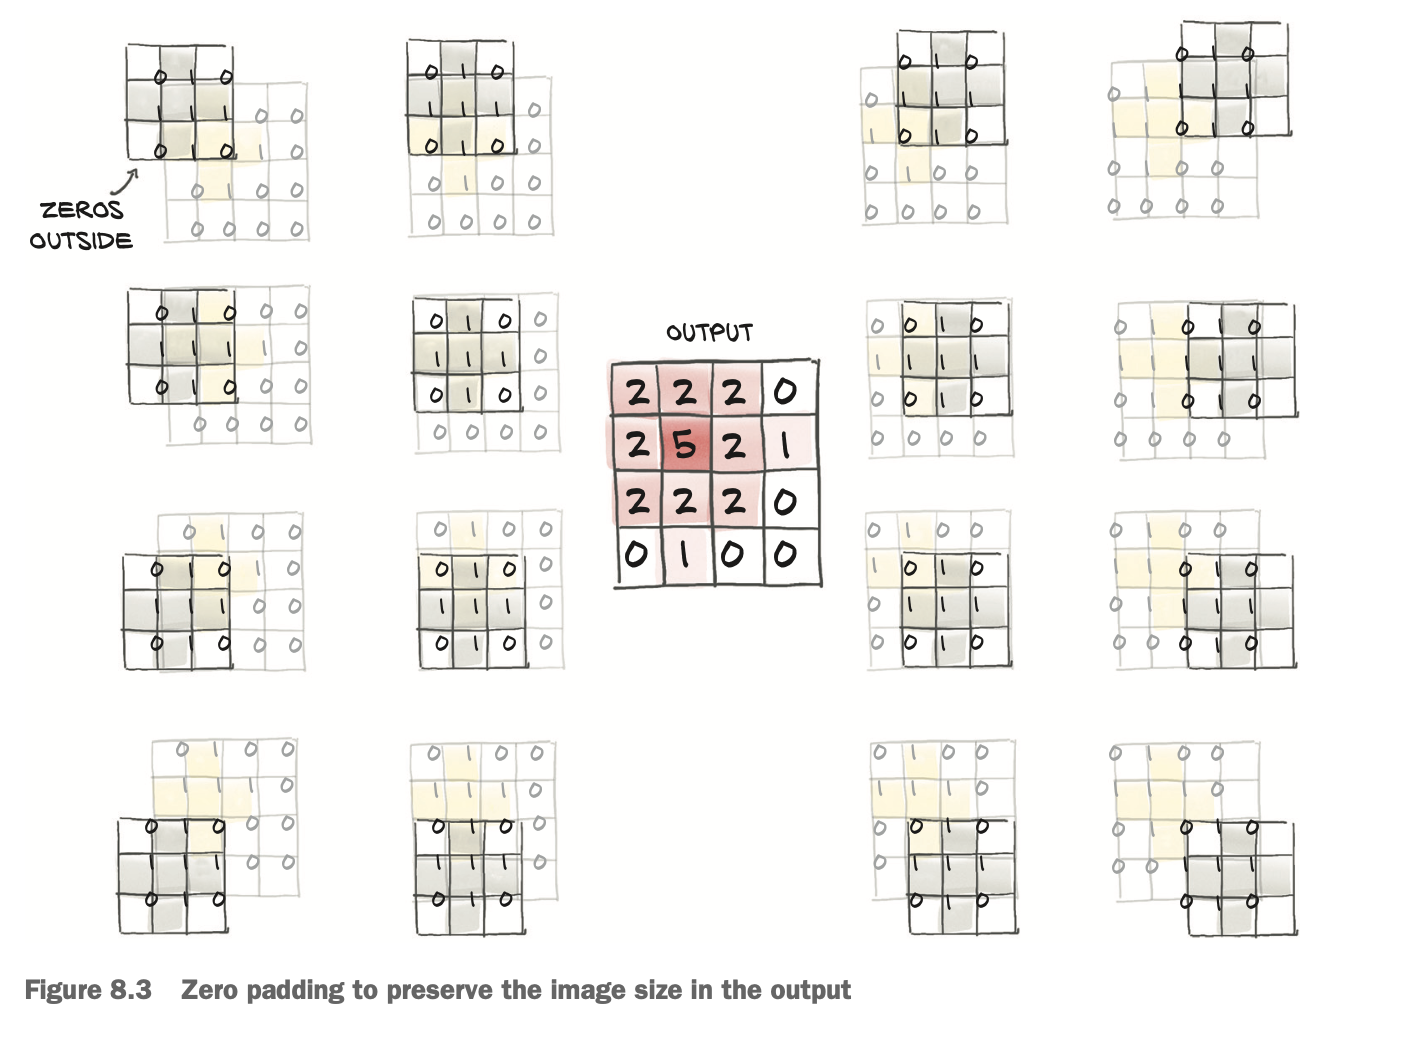

In [ ]:
conv = nn.Conv2d(
    in_channels=3,
    out_channels=1,
    kernel_size=3,
    padding = 1 # 패딩 추가
    )
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

- 패딩 사용 여부와 관계없이 weight와 bias의 크기는 변하지 않는다.

In [ ]:
conv.weight.shape, conv.bias.shape

#### Convolution에서 padding을 사용하는 이유

1. 패딩을 통해 컨볼루션과 이미지 크기 변경 문제를 별도로 분리해 기억해야하는 사항을 하나 줄이는데 도움을 준다.
    - 만약 패딩 없이 컨볼루션을 계속 적용하면, 네트워크 깊이가 깊어질수록 이미지 크기가 급격히 줄어들어서 이때마다 크기 변화를 신경써줘야한다.
    - 패딩을 사용하면 컨볼루션 연산 자체와 이미지 크기 변화 문제를 분리해서 생각할 수 있다.
2. 컨볼루션 구조 자체에 더 신경쓸 수 있다.

### 8.2.2 컨볼루션으로 피처 찾아내기

In [ ]:
with torch.no_grad():
    conv.bias.zero_()
    # bias를 0으로 만들자
with torch.no_grad():
    # 이 블록 안의 연산은 autograd(자동 미분)에 기록되지 않는다. 학습 중이 아니라 직접 파라미터를 수정할 때 사용한다.
    conv.weight.fill_(1.0/9.0)
    # 합성곱 레이어의 가중치(필터 값)을 모두 1/9로 채우는 작업

In [ ]:
output = conv(img.unsqueeze(0))# 0번째 축에 1차원 추가
plt.imshow(output[0,0].detach(),cmap='gray')
plt.show()

# .detach()를 안할 경우
# Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

- 이미지가 흐려졌다.
- 각 출력 픽셀은 자신의 주변 픽셀에 대한 평균이기 때문에 출력 픽셀에서 이러한 상관관계를 반영해 픽셀 간의 변화가 부드러워졌다.
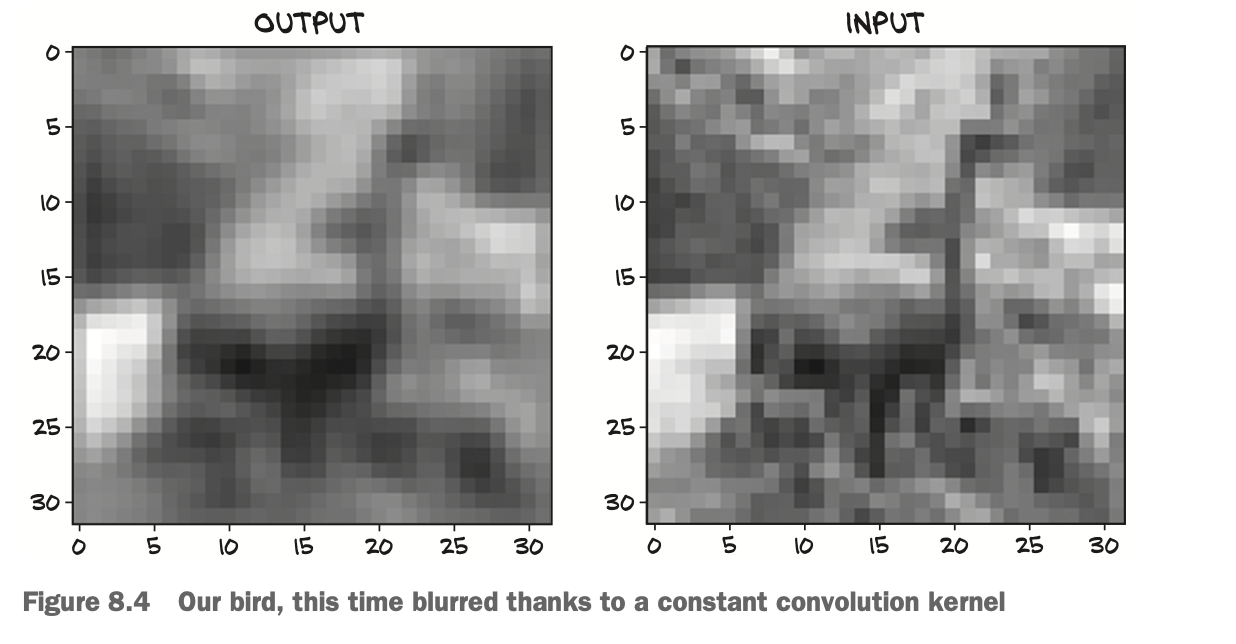

#### 여기서 잠깐 , detach()는 무슨 역할을 할까?

- Pytorch에서 신경망을 학습할 때, 텐서 연산들은 계산그래프 (computational graph)에 연결돼서 나중에 역전파(backpropagation)로 자동 미분이 가능하다.
- 하지만 시각화나 numpy 변환 또는 단순히 결과만 보고 싶을 때는 gradient 추적이 필요없다.
- 이럴 때 .detach()를 사용하면, 해당 텐서를 계산 그래프에서 분리해서 이후 연산이 autograd에 기록되지 않게 할 수 있다.


In [ ]:
from torchviz import make_dot

y = conv(img.unsqueeze(0))
make_dot(y, params=dict(conv.named_parameters())).render("model_graph", format="png")


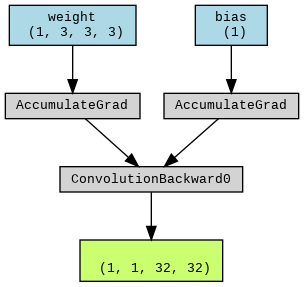


#### Computational graph 해석
1. weight(1,3,3,3)
    - 합성곱 레이어의 가중치(필터) 의미
    - 1개의 출력 채널, 3개의 입력채널, 3*3 커널
2. bias(1)
    - 각 출력 채널마다 더하는 바이어스값
    - shape가 (1,) 라는 뜻
3. AccumulateGrad
    - weight와 bias 각각의 gradient(기울기)를 누적하는 노드
    - 역전파가 오면 여기서 파라미터의 gradient가 저장됨
4. ConvolutionBackward0
    - 합성곱 연산의 backward 연산
    - 실제로 gradient를 계산하는 핵심 함수 노드
    - 이 위치에서 입력, weight, bias의 gradient가 계산됨
5. (1,1,32,32)
    - 합성곱 레이어의 출력 텐서 shape
    - 1개의 배치, 1개 채널, 32*32 크기

In [ ]:
conv.bias.data
print(conv.weight.grad)
print(conv.bias.grad)
# AccumulateGrad에 저장된 값 = 파라미터 텐서(예: weight, bias)의 .grad 속성 값

In [ ]:
# 이제 다시 책으로 돌아가서 ,,, 커널을 조금 바꿔보자
conv = nn.Conv2d(3,1,kernel_size=3,padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0,0.0,1.0],
    [-1.0,0.0,1.0],[-1.0,0.0,1.0]
                                   ])
    conv.bias.zero_()

In [ ]:
output = conv(img.unsqueeze(0))

plt.imshow(output[0,0].detach(),cmap='grey')
plt.show()

In [ ]:
plt.imshow(img.permute(1,2,0),cmap='grey')
plt.show()

- 만약 커널이 밝기가 다른 부분의 경계에 걸쳐있다면 한쪽(오른쪽)은 밝고, 다른쪽은 어두우면
    - 두 값의 차이가 커져서 o22는 큰값이 된다.
- 이미지의 한 영역이 모두 같은 밝기라면
    - 오른쪽과 왼쪽의 값이 비슷해서 022는 0에 가까워진다.
- 이런 커널은 수평방향의 경계를 강조한다.
    - 수평으로 인접한 두 영역의 밝기 차이가 클 때만 출력이 커져서 경계가 뚜렷하게 드러난다.
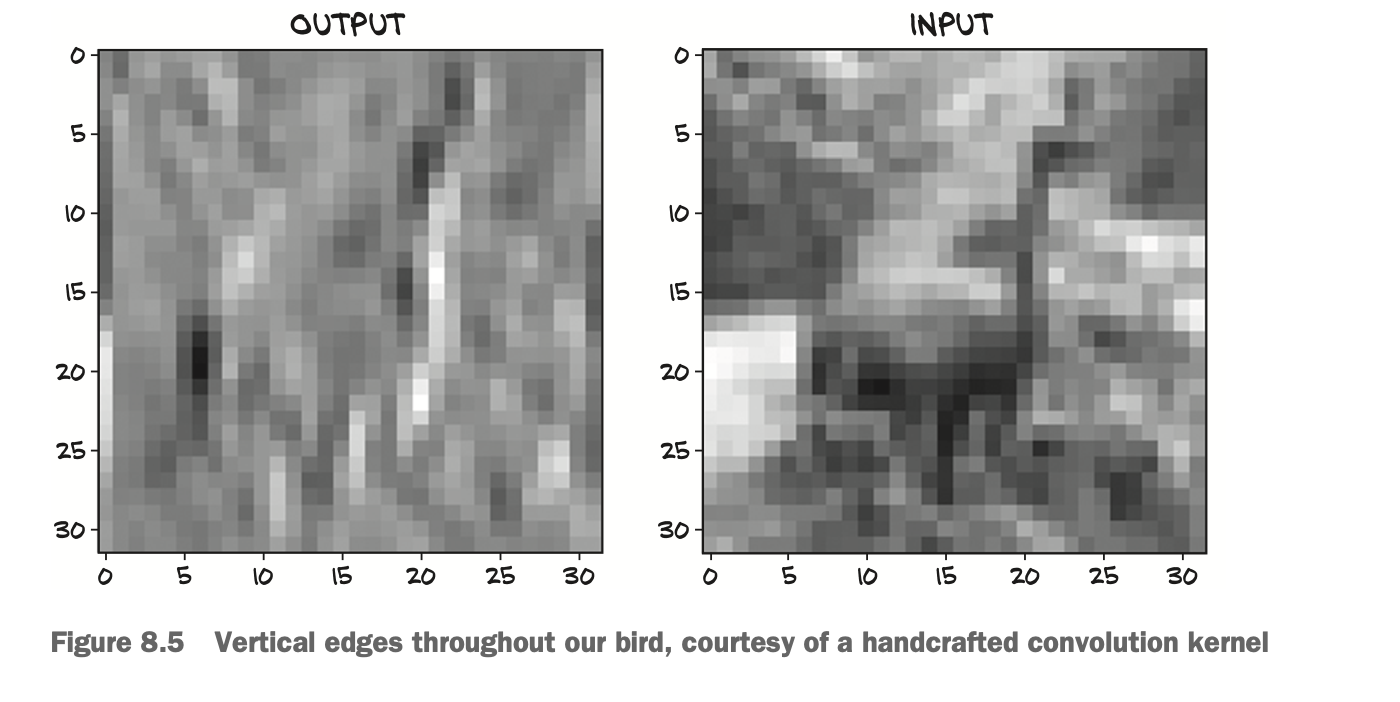

#### 컨볼루션 신경망의 역할
- From this angle, the job of a convolutional neural network is to estimate the kernel of a set of filter banks in successive layers that will transform a multichannel image into another multichannel image, where different channels correspond to different
features (such as one channel for the average, another channel for vertical edges, and
so on).

1. CNN은 필터 뱅크(커널 집합)을 학습한다.
    - CNN의 각 레이어에는 여러 개의 필터가 있다.
    - 각 필터는 입력 이미지의 여러 채널을 받아서, 특정 패턴(평균, 엣지, 질감)등을 추출하는 역할을 한다.
    - 이 필터들은 학습 과정에서 자동으로 최적화되어 , 입력 이미지를 점점 더 유용한 특징으로 변환한다.
    
2. 여러 채널 = 여러 특징
    - CNN의 출력은 여러 채널(feature map)으로 구성된다.
        - 예를 들어 한 채널이 "평균 밝기", 다른 채널은 "수직 엣지", 또 다른 채널은 "특정 질감" 등 다양한 특징을 나타낼 수 있다.
        - **각 채널의 하나의 필터가 입력 전체에 적용된 결과**
    
3. 연속된 레이어에서 점점 복잡한 특징 추출
    - 첫 번째 레이어는 단순한 패턴(선, 모서리 등)을 추출
    - 그 다음 레이어들은 이전 레이어의 특징맵을 입력으로 받아, 더 복잡한 패턴을 추출한다. (모양, 질감, 객체 등)
4. 커널을 자동으로 학습한다.
    - CNN은 필터값들을 사람이 직접 설계하지 않고, 데이터와 손실함수에 따라 자동으로 학습한다.

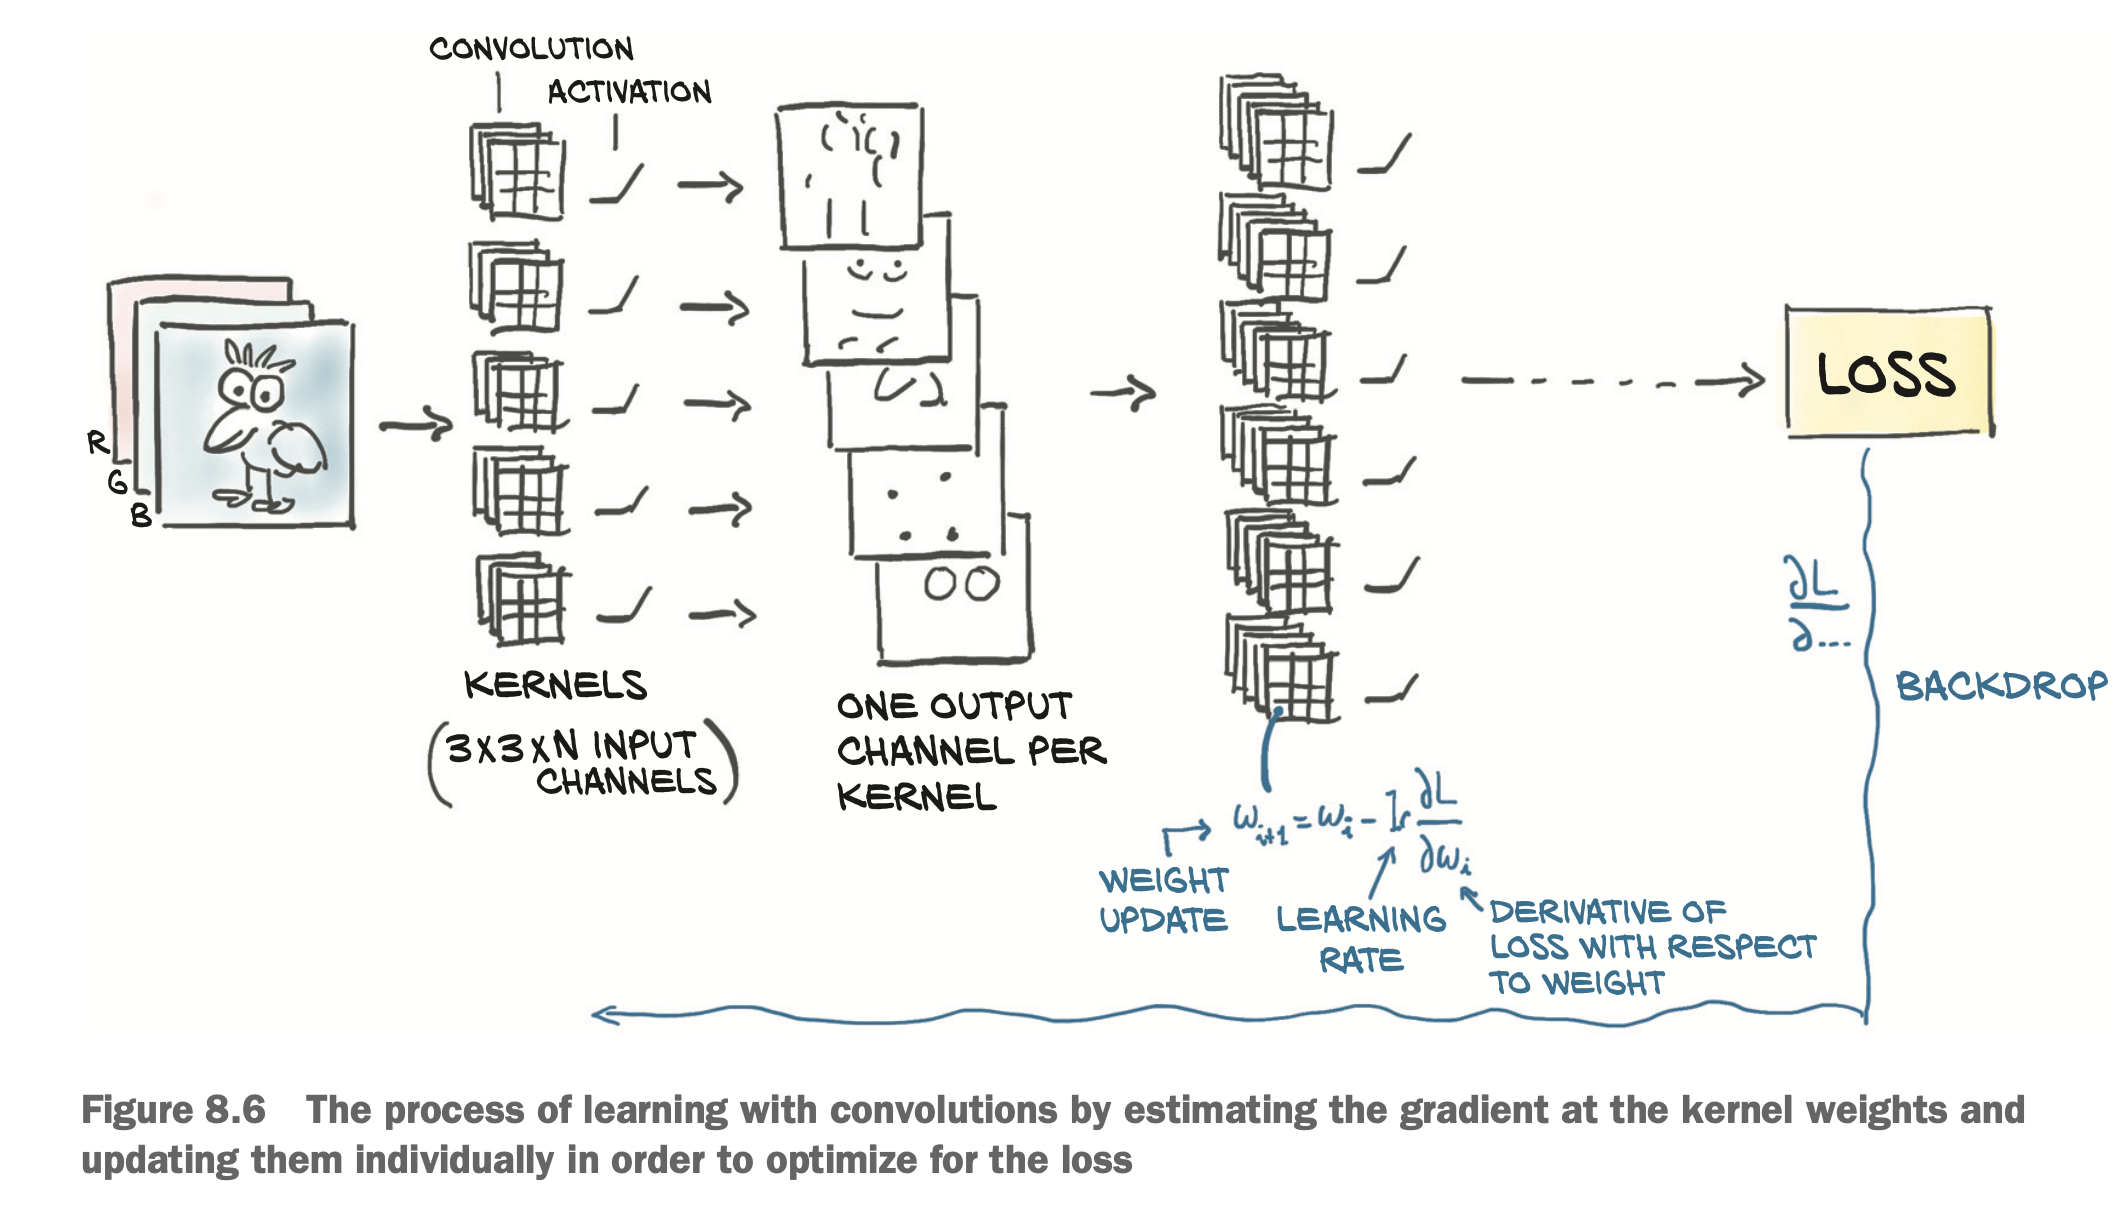

### 8.2.3 깊이와 풀링으로 한 단계 더 인식하기

- `3*3`이나 `5*5` 같은 작은 커널을 사용하길 추천했다.
- 이게 지역성의 한계이다.
    

> 지역성이란 ? each neuron(or each filter in a convolutional layer) only look at a small, local region of the input image.


- 만약 이미지 내 그림이 꽤 크다면 어떻게 하지?
    - 이미지 안의 물체나 구조가 3픽셀이나 5픽셀밖에 안될까? 그건 알 수가 없다.
- 더 큰 범위에서 신경망이 패턴을 인식하게 하려면 어떻게 해야할까?
- 새와 비행기를 효과적으로 구별하려면 이에 대한 해결책이 필요하다.


#### 큰 이미지에서 작은 이미지로 : 다운 샘플링

이미지를 반으로 줄이는 것은 이웃하는 네 개의 픽셀을 입력받아 한 픽셀을 출력하는 작업과 동일하다.

- 네 개의 입력값에 대해 어떤 값 하나를 출력할 것인지는 우리가 정할 수 있다.

- average pooling : 4개의 픽셀을 평균하기 , 요즘은 잘 사용하지 않는다.
- max pooling : 4개의 픽셀 중 최댓값
- 스트라이드하며 컨볼루션을 수행하되 n번째 픽셀만 계산하기

-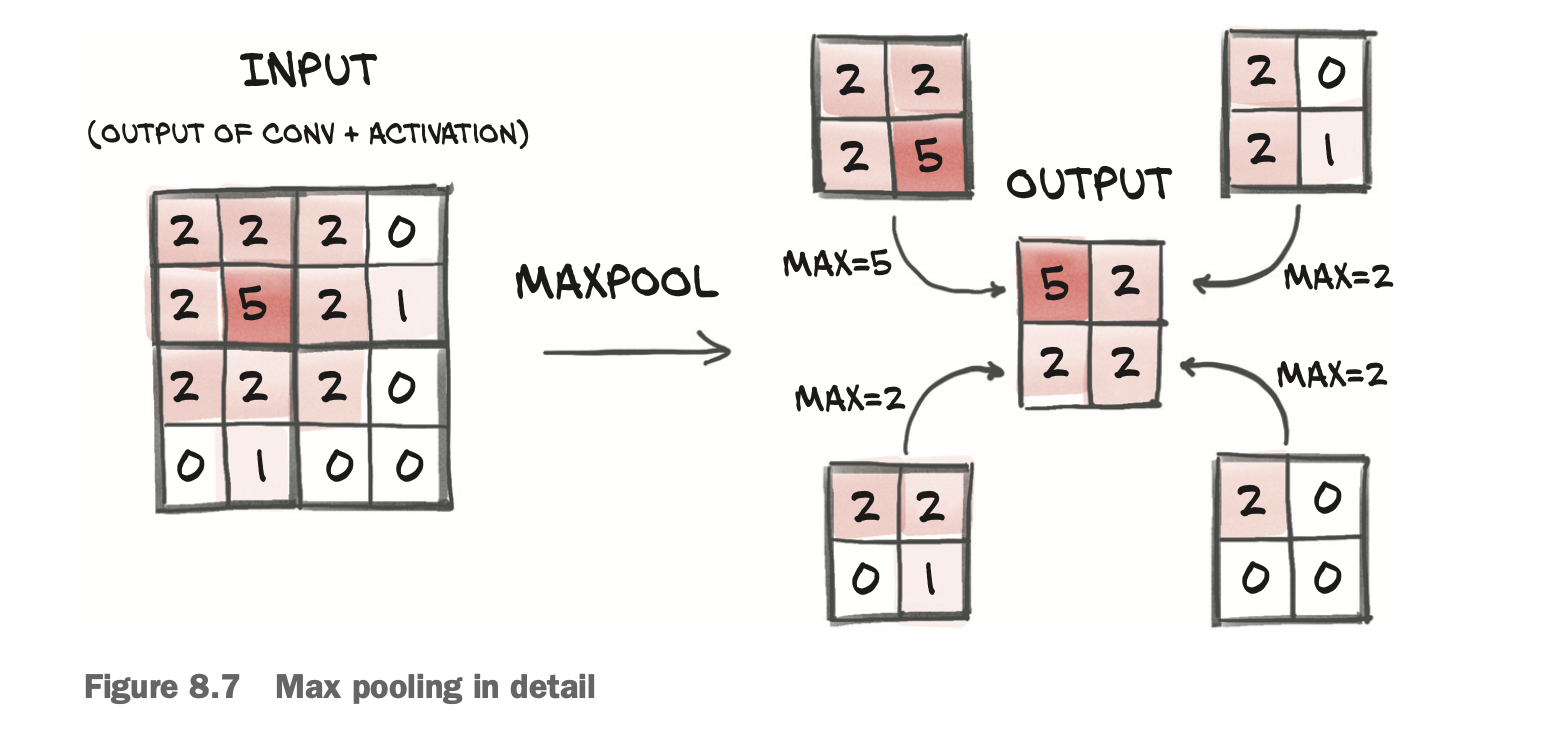


- 활성함수로 연결되므로 컨볼루션층의 출력이미지의 각 값은 특정 커널에 대응하는 패턴이 발견될 때 높은 값을 가진다.
- 다운 샘플링을 통해 2*2 인접 픽셀에서 최댓값을 뽑는 것은 약한 신호는 버리고 살아남은 피처를 발견하는 과정

In [ ]:
pool = nn.MaxPool2d(2)

output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

#### 더 나은 성능을 위해 컨볼루션과 다운 샘플링 결합하기
'''
이제 컨볼루션과 다운샘플링의 조합이 얼마나 큰 패턴을 식별해내는지 살펴보자 .

1. 8*8 이미지에 대해 3*3 커널을 적용하여 같은 크기의 멀티 채널 출력 이미지를 얻는다.
    -  어떻게 같은 크기의 이미지를 얻나? -> 패딩을 적용해서
2. 출력 이미지를 반으로 줄여 4*4 이미지를 얻고 다른 3*3 커널을 적용한다.
3. 두 번재 커널셋은 반으로 줄어든 이미지 안에서 3*3 인접 픽셀에 대해 동작하므로 원래 입력의 8*8 인접 영역에 대해 효과적으로 동작하는 셈이다.
    - 두 번째 커널셋(the second set kenels)는 첫번째 커널셋의 피처(output of the first set f kenels)를 받아 추가적인 피처를 추출한다(extract additional features on top of those).
4. 첫번째 커널셋이 먼저 작은 영역 내에서 1차로 서주순의 피처에 대해 동작하고,
5. 두 번째 커널셋이 이렇게 얻은 피처들을 합성한 피처를 만들고,  좀 더 넓은 범위에서 동작한다.
'''

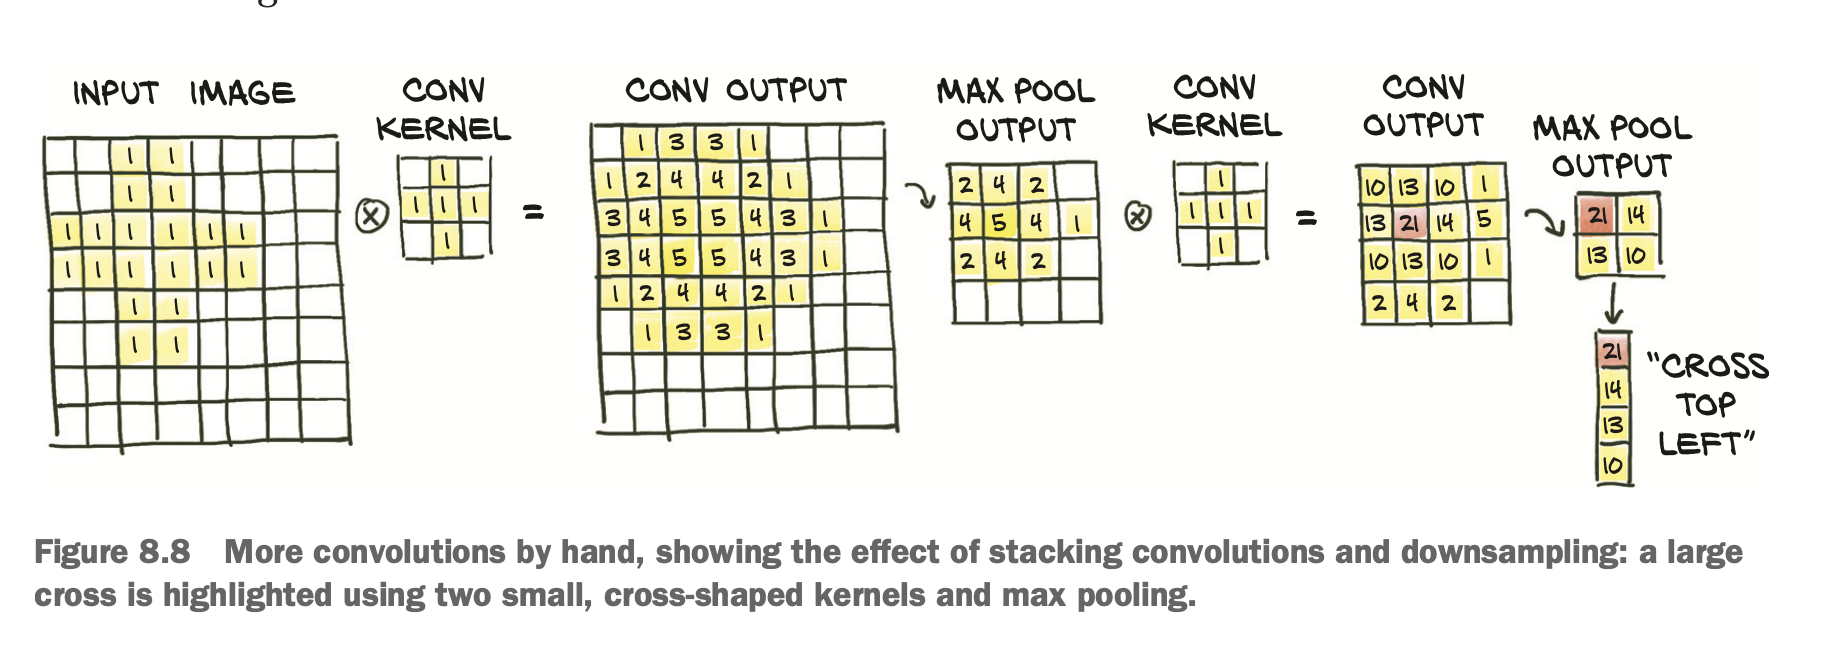

### 8.2.4 우리의 신경망에 적용하기

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,padding=1), # 3 RGB채널을 16, 16개의 독립적인 피처(16개의 필터 적용의 결과)로 만들어 새와 비행기에 대한 저수준의 피처를 찾아낸다.
    nn.Tanh(),
    nn.MaxPool2d(2), # 16 채널의 16*16 이미지로 다운샘플링
    nn.Conv2d(16,8,kernel_size=3, padding=1),# 8채널 16*16 출력 만든다. 이 출력은 좀 더 높은 수준의 피처를 가질 것
    nn.Tanh(),
    nn.MaxPool2d(2), # 8채널 8*8 출력

)


-  입력 이미지가 8*8 피처 세트로 줄어들고 난 후 이 신경망은 결국 음의 로그가능도(NLL)로 넣을 수 있는 확률값을 뽑아줘야한다.
-  확률은 1차원 벡터인 숫자쌍으로 나와야하는데(하나느 비행기, 다른 하나는 새)
-  지금은 멀티 채널의 2차원 피처인 상태이다.


-  8개의 채널 , 8*8 이미지를 1차원 벡터로 바꿔서 완전 연결계층으로 신경망을 마무리해야한다.

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,padding=1), # 3 RGB채널을 16, 16개의 독립적인 피처(16개의 필터 적용의 결과)로 만들어 새와 비행기에 대한 저수준의 피처를 찾아낸다.
    nn.Tanh(),
    nn.MaxPool2d(2), # 16 채널의 16*16 이미지로 다운샘플링
    nn.Conv2d(16,8,kernel_size=3, padding=1),# 8채널 16*16 출력 만든다. 이 출력은 좀 더 높은 수준의 피처를 가질 것
    nn.Tanh(),
    nn.MaxPool2d(2), # 8채널 8*8 출력
    nn.Flatten(),
    nn.Linear(8*8*8, 32), # 왜 32개이지?? 임의로 적용한거였음.
    nn.Tanh(),
    nn.Linear(32,2)
)


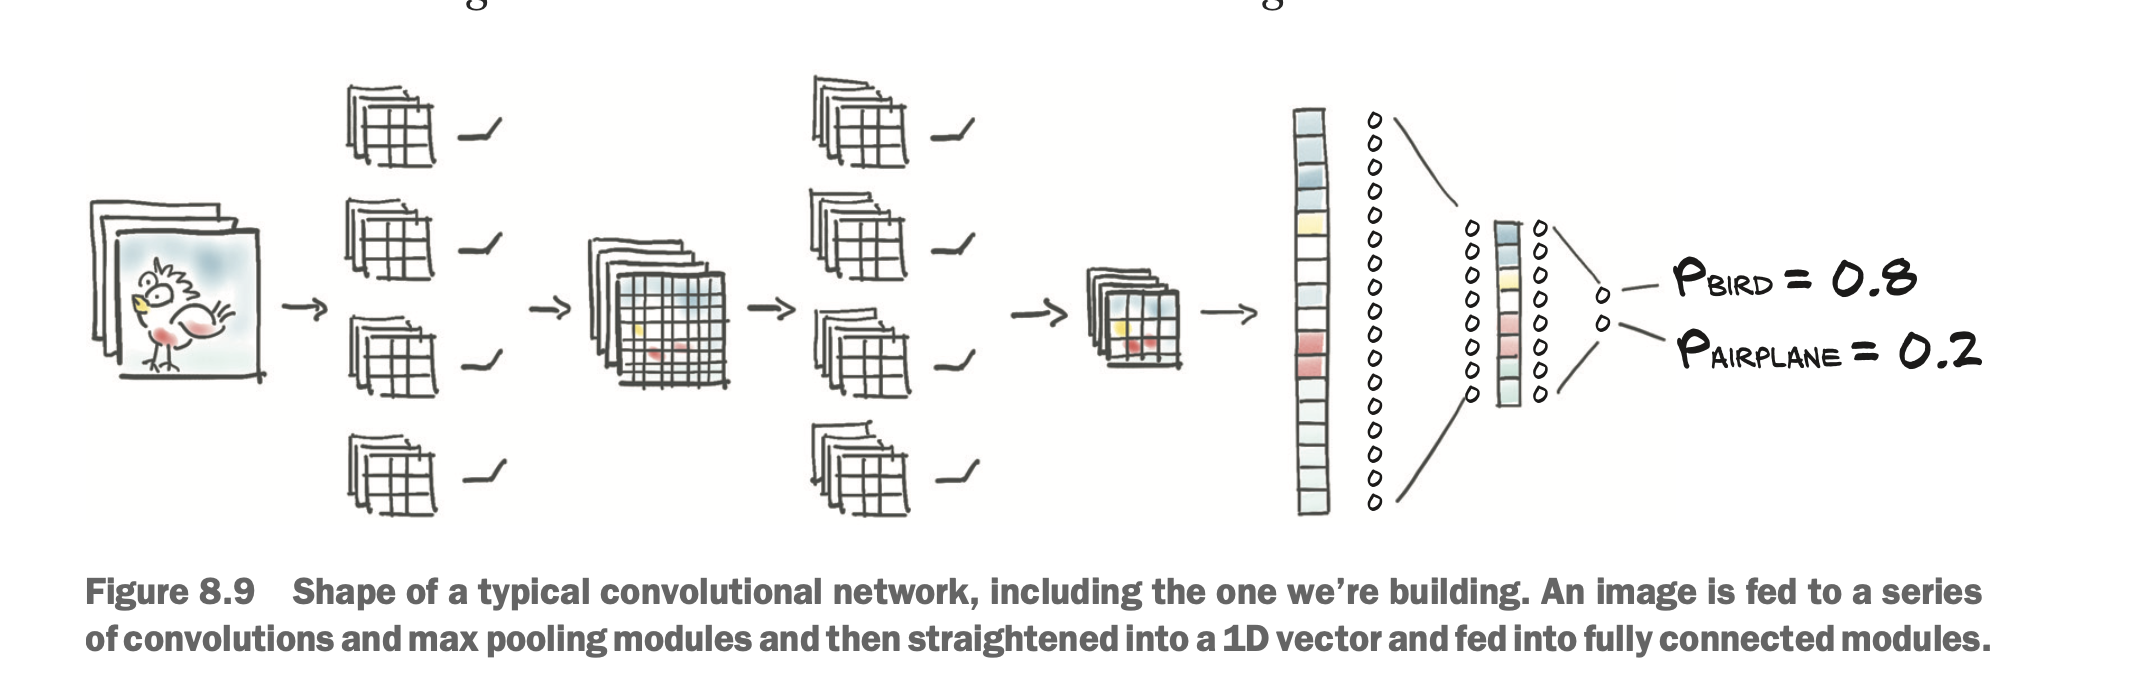

#### 그림 설명
1. 입력
    - 여러 장의 이미지를 입력으로 받는다.
    - 시작 입력 이미지는 보통 RGB 3채널이다.
2. 합성곱(Convolution)과 풀링(Max Pooling)
    - 이미지를 여러 필터(커널)로 convolution해서 각기 다른 특징(엣지, 패턴 등)을 추출
    - 이렇게 하면 여러 개의 특징맵(channel)이 생성되고, 각각의 맵은 서로 다른 정보를 담고 있다.
    - 여러 층을 반복해가면서 맵의 크기느 줄어들고(공간적으로 다운 샘플링), 채널 수는 늘어나거나 변화한다.
    - 풀링(max pooling)은 정보를 집약해 표현한다.
3. Flatten
    - 마지막 특징 맵들은 1차원 벡터로 flatten 된다.
    - 특징맵(2D, 여러 채널)이 1D 벡터로 변환된다.
4. 완전 연결 신경망(FC : fully connected layers)
    - 평탄화된 1D 벡터가 1~2개 이상의 완전 연결레이어(FC)를 거치며 적절히 정보를 조합한다.
5. 출력
    - 마지막 레이어에서 분류확률(p)로 변환된다.
    - 각각의 숫자는 해당 클래스일 확률을 의미한다.

- 선형 계층의 크기가 MaxPool2d의 출력 크기 `8*8*8 `= 512에 의존성을 가진다?
    - 마지막에 MaxPool2d를 통과한 출력 크기가 완전 연결 레이어의 입력 차원을 결정한다.
    - 마지막 MaxPool2d 출력 크기가 8*8, 채널이 8개라면,
    - 이걸 평탄화하면 벡터 길이는 `8*8*8` = 512이다.
    - 따라서 nn.Linear(512, N)가 된다.
- 모델의 용량(capacity)를 늘리기
    - capacity : 신경망이 배울 수 있는 표현의 다양성(복잡도)
    - 만약 conv레이어의 출력 채널 수(필터 개수)를 늘리면
        - 한번에 추출하는 피처의 수가 늘어나 더 복잡한 패턴을 배울 수 있다.
        - 출력되는 채널이 많아지면, 마지막 선형 레이어로 가는 입력 벡터의 길이도 늘어나서 Linear 레이어의 파라미터 수도 같이 증가한다.
        - 모델 용량이 커진다.

In [ ]:
numel_list = [ p.numel() for p in model.parameters()]
sum(numel_list), numel_list

In [ ]:
model(img.unsqueeze(0))


'''
#### nn.Flatten을 적어주지 않을 경우 발생 에러

- RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)
- 에러 이유 : # 완전 연결 레이어에 들어가는 입력 벡터 크기와 레이어가 기대하는 입력 크기가 맞지 않아서 생긴 일이다.
- 해결 : FC 전 nn.Flatten()을 추가해주면 된다.
'''


# 8.3 nn.Module 서브클래싱하기

### 8.3.1 nn.Module로 정의된 우리의 신경망

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3,16,kernel_size=3,padding=1), # 3 RGB채널을 16, 16개의 독립적인 피처(16개의 필터 적용의 결과)로 만들어 새와 비행기에 대한 저수준의 피처를 찾아낸다.
    nn.Tanh(),
    nn.MaxPool2d(2), # 16 채널의 16*16 이미지로 다운샘플링
    nn.Conv2d(16,8,kernel_size=3, padding=1),# 8채널 16*16 출력 만든다. 이 출력은 좀 더 높은 수준의 피처를 가질 것
    nn.Tanh(),
    nn.MaxPool2d(2), # 8채널 8*8 출력
    nn.Flatten(),
    nn.Linear(8*8*8, 32), # 왜 32개이지?? 임의로 적용한거였음.
    nn.Tanh(),
    nn.Linear(32,2)
)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.flt = nn.Flatten()
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 =nn.Tanh()
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = self.pool1(self.act1(self.conv1 ))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.flt(out) # out = out.view(-1. 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

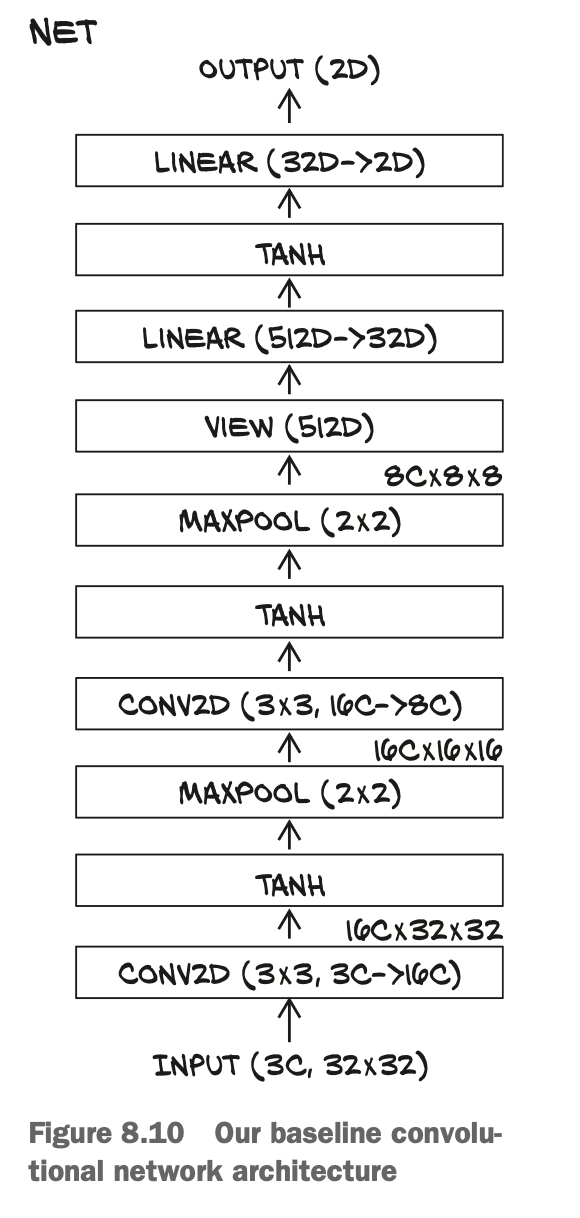

#### 분류 신경망의 목적
-  큰 수의 픽셀을 가진 이미지에서 출발해 정보를 압축해가면서 분류 클래스의 확률 벡터를 만들어 가는 것이다.

1. 중간에 나타나는 값의 개수가 점점 줄어드는 모습에 우리가 목표하는 바가 반영되어있다.
2. 최초의 컨볼루션에서는 입력 크기에 대해 출력 크기가 줄어들지 않는다.
    - ex : 출력 픽셀 하나를 32개의 요소를 가진 벡터,, 27개의 요소(3채널 * 3*3 커널 크기를 가지는 conv)를 가지는 선형 변환에 해당하며 어느 정도 증가하는 셈이다.
    - 보통 첫 conv layer는 패딩을 사용한다.
        - 이로 인해 공간적 크기는 줄어들지 않는다.
    - 출력 픽셀 하나가 벡터라는 의미
        - 컨볼루션 레이어는 여러 개의 필터를 사용한다.
        - ex : 32개의 3*3*3 커널을 사용하면 , 출력의 각 위치는 32개의 값(32차원 벡터)을 가지게 된다.
        - 이 32개의 값은 각각 다른 필터가 해당 위치에서 추출한 특징을 의미한다.
    - 선형 변환과의 연결
        - 각 출력 픽셀은 입력의 3채널 3*3*3 = 27개의 값에 대해 선형 결합을 한 결과다.
        - 즉 출력 픽셀 하나는 27차원 입력 벡터에 대한 선형 변환 결과이다.
        이 과정에서 출력의 채널 수 만큼 정보가 늘어나는 셈
            - 입력의 한 픽셀은 3개의 값(RGB)만 갖지만, 출력의 한 픽셀은 32개의 값(32채널)로 정보가 늘어나는 것처럼 보인다.


### 8.3.2 파이토치가 파라미터와 서브 모듈을 유지하는 방법

In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list),numel_list


#### model.parameters()
- 생성자에서 속성으로 할당된 모든 서브 모듈을 찾아
이들의 parameters()를 재귀적으로 호출한다.

- 생성자에서 속성으로 할당된 모든 서브 모듈??
    - nn.Module을 상속받아 신경망 모델을 만들 때, __init__에서 레이어(모듈)을 속성으로 할당한다.
    - self.conv1, self.act1, self.pool1처럼 모델의 멤버 변수로 등록된 모든 레이어와 모듈을 의미

#### 파라미터가 없는 nn.Tanh()나 nn.MaxPool2d 같은 서브 모듈은 굳이 등록할 필요가 없는 것 같다?!

- 그냥 forward함수에서 직접 호출하는게 더 좋지 않을까?

### 8.3.3 함수형 API
- nn.Linear와 nn.Conv2D를 사용해서 Net이 훈련하는 동안 파라미터를 관리하는 것은 필요하다.
- 풀링과 활성 함수의 경우 파라미터가 없으므로 안전하게 함수형으로 대체가능하다.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(16,8,kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        #out = self.flt(out)
        out = out.view(-1, 8*8*8) # 1차원 벡터로 만들어주기
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = Net()
model(img.unsqueeze(0))
# tensor([[0.1351, 0.0086]], grad_fn=<AddmmBackward0>)


# 8.4 우리가 만든 컨볼루션 신경망 훈련시키기
- 우리가 만든 컨볼루션 신경망은 중첩된 두 루프를 가지고 있다
- 바깥 루프는 epoch 단위로 돌고, 안쪽 루프는 Dataset에서 배치를 만드는 DataLoader 단위로 돈다.

#### 각 루프에서 우리가 할 일
    1. 모델에 입력값을 넣고(순방향 전달)
    2. 손실값을 계산하고(순방향 전달)
    3. 이전 기울기값을 0으로 리셋하고
    4. loss.backward()를 호출하여 모든 파라미터에 대한 손실값을 기울기를 계산(역방향 전달)
    5. 이후 옵티마이저를 통해 손실값을 낮추도록 파라미터를 조정한다.

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1): # <- 에포크는 0대신, 1부터 n_epochs까지 루프를 돌게 한다.
        loss_train = 0.0
        for imgs, labels in train_loader: # <- 데이터 로더가 만들어준 배치 안에서 데이터셋을 순회한다.
            outputs = model(imgs)  # <- 모델에 배치를 넣어준다.

            loss = loss_fn(outputs, labels) # <- 최소화하려는 손실을 계산한다.

            optimizer.zero_grad() # <- 마지막 이전 기울기 값을 지운다.

            loss.backward() # <- 역전파 수행, 신경망이 학습할 모든 파라미터에 대한 기울기를 계산함

            optimizer.step() # <- 모델 업데이트

            loss_train += loss.item() # <- 에포크 동안 확인할 손실값을 모두 더한다. 기울기 값을 꺼내고자 .item()을 사용해 손실값을 파이썬 수로 변환 !!

        if epoch == 1 or epoch % 10 == 0 :
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch, loss_train / len(train_loader))) # <- 배치 단위의 평균 손실값을 구하기 위해 훈련 데이터 로더의 길이(배치 크기)로 나눠준다.


In [ ]:
import torch
train_loader = torch.utils.data.DataLoader(cifar2, batch_size = 64, shuffle = True)

model= Net()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


### 8.4.1 정확도 측정

In [ ]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size = 64, shuffle = False
)

val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size = 64, shuffle = False
)

def validate(model, train_loader, val_loader):
    for name, loader in [("train",train_loader) , ("val",val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad(): # 파라미터를 업데이트하지 않을 것이므로 기울기는 필요없다.
            for imgs, labels in loader:
                outputs= model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 가장 높은 값을 가진 인덱스를 출력
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print(f" Accuracy {name} : {correct/total}")

validate(model, train_loader, val_loader)

### 8.4.2 모델을 저장하고 불러오기

In [ ]:
torch.save(model.state_dict(), data_path + "bird_vs_airplaines.pt")

loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path +"bird_vs_airplaines.pt" , map_location = device))


### 8.4.3 GPU에서 훈련시키기

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
else torch.device('cpu'))

print(f"training on device {device}")

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1): # <- 에포크는 0대신, 1부터 n_epochs까지 루프를 돌게 한다.
        loss_train = 0.0
        for imgs, labels in train_loader: # <- 데이터 로더가 만들어준 배치 안에서 데이터셋을 순회한다.

            '''
            imgs와 labels를 옮기는 이 두줄만 이전과 다르다
            '''
            imgs = imgs.to(device = device)
            labels = labels.to(device= device)

            outputs = model(imgs)  # <- 모델에 배치를 넣어준다.

            loss = loss_fn(outputs, labels) # <- 최소화하려는 손실을 계산한다.

            optimizer.zero_grad() # <- 마지막 이전 기울기 값을 지운다.

            loss.backward() # <- 역전파 수행, 신경망이 학습할 모든 파라미터에 대한 기울기를 계산함

            optimizer.step() # <- 모델 업데이트

            loss_train += loss.item() # <- 에포크 동안 확인할 손실값을 모두 더한다. 기울기 값을 꺼내고자 .item()을 사용해 손실값을 파이썬 수로 변환 !!

        if epoch == 1 or epoch % 10 == 0 :
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch, loss_train / len(train_loader))) # <- 배치 단위의 평균 손실값을 구하기 위해 훈련 데이터 로더의 길이(배치 크기)로 나눠준다.


In [ ]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size = 64, shuffle = False
)

val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size = 64, shuffle = False
)

# model = Net().to(device= device) # 모델을 GPU로 옮긴다.
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
# loss_fn= nn.CrossEntropyLoss()

def validate(model, train_loader, val_loader):
    for name, loader in [("train",train_loader) , ("val",val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad(): # 파라미터를 업데이트하지 않을 것이므로 기울기는 필요없다.
            for imgs, labels in loader:
                imgs = imgs.to(device = device)
                labels = labels.to(device= device)

                outputs= model(imgs)
                _, predicted = torch.max(outputs, dim=1) # 가장 높은 값을 가진 인덱스를 출력
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            print(f" Accuracy {name} : {correct/total}")



In [ ]:
training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

In [ ]:
validate(model, train_loader, val_loader)

#### 발생한 에러

- RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor
- 원인 : 입력 텐서가 CPU에 있는데 모델의 weight는 GPU에 있음
- 해결 : 입력 텐서와 모델을 같은 디바이스에 올려야한다.

In [ ]:
loaded_model

# 8.5 모델 설계

- 좀 더 복잡한 문제가 나타나면 어떻게 해야할까?
- 더 크고 복잡한 이미지에서 답을 찾으려면 여러 시각적 단서를 찾기 위해 계층적인 구조화가 필요하다.

### 8.5.1 메모리 용량 늘리기 : 너비
#### 신경망의 너비(width) 차원
- 이는 신경망 계층 내의 뉴런 수 or 컨볼루션의 채널 수에 해당하는 값이다.


In [ ]:
class NetWidth(nn.Module):
    def __init__(self,n_chans1= 32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3,n_chans1,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(n_chans1,n_chans1//2,kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*n_chans1//2, 32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        #out = self.flt(out)
        out = out.view(-1, (self.n_chans1//2)*8*8) # 1차원 벡터로 만들어주기
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth().to(device = device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)
loss_fn= nn.CrossEntropyLoss()

sum(p.numel() for p in model.parameters())

- 각 계층에서 채널과 피처의 수를 나타내는 숫자들은 직접적으로 모델의 파라미터 수에 영향을 미친다.
- 다른 부분이 다 동일한 경우 이런 변화는 모델의 용량(capacity)를 증가시킨다.
- 용량이 클수록 모델이 다룰 수 있는 입력은 더 다양해진다.
    - 동시에 과적합 가능성도 커진다(파라미터가 많아져서 입력에서 불필요한 부분까지 기억해버릴 수 있기 때문)

### 8.5.2 모델이 수렴하고 일반화하도록 돕는 방법 : 정규화
- 과적합을 제어하기 위해 데이터가 아니라 모델 레벨에서 다룰 수 있는 기법

- 모델 훈련은 중요한 2단계를 거친다.
    1. 최적화 단계 : 훈련셋에 대해 손실값을 줄이는 경우
    2. 일반화 단계 : 모델이 훈련셋뿐 아니라 이전에 겪어보지 않은 검증셋 데이터에 대해서도 동작하게 하는 것

- 이 2단계를 위한 수학적 도구를 정규화(regularization)이라고 한다.

#### 파라미터 제어하기 : 가중치 패널티
- 일반화(generalization)을 안정적으로 수행하기 위한 첫번째 방법은 손실값에 정규화 항을 넣는 것이다.
- 가중치 항을 조작해서 모델의 가중치가 상대적으로 작게 만든다.
    - 훈련을 통해 증가할 수 있는 크기를 제한하는 것이다(큰 가중치에 패널티를 부과한느 것)
- 이렇게 하면 손실값은 다소 매끄러운 등고선 형태를 띠고, 개별 샘플에 맞춰서 얻는 이득이 상대적으로 줄어든다.

#### L2 정규화,  L1 정규화
- L2 정규화 : 모델의 모든 가중치에 대한 제곱합
- L1 정규화 : 모델의 모든 가중치의 절댓값의 합
- 우리는 L2 정규화에 집중하자

#### L2 정규화
- weight decay 가중치 감쇠라고도 한다.
- 파라미터 w_i에 대한 L2 정규화의 음의 기울기 : -2 * lambda * w_i
- 손실함수에 L2 정규화를 더하는 것은 최적화 단계(훈련셋에 대한 손실값 줄이기)에서 현재 값에 비례해서 각 가중치를 줄이는 역할
    - 현재 가중치값에 비례해서 각 가중치를 줄이는 역할을 하는 것

In [ ]:

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1): # <- 에포크는 0대신, 1부터 n_epochs까지 루프를 돌게 한다.
        loss_train = 0.0
        for imgs, labels in train_loader: # <- 데이터 로더가 만들어준 배치 안에서 데이터셋을 순회한다.


            # imgs와 labels를 GPU로 옮기기

            imgs = imgs.to(device = device)
            labels = labels.to(device= device)


            outputs = model(imgs)  # <- 모델에 배치를 넣어준다.

            loss = loss_fn(outputs, labels) # <- 최소화하려는 손실을 계산한다.

            # '''
            # L2 정규화 추가
            # '''
            # l2_lambda = 0.001
            # l2_norm = sum( p.pow(2.0).sum() for p in model.parameters())

            # loss = loss + l2_lambda * l2_norm


            optimizer.zero_grad() # <- 마지막 이전 기울기 값을 지운다.

            loss.backward() # <- 역전파 수행, 신경망이 학습할 모든 파라미터에 대한 기울기를 계산함

            optimizer.step() # <- 모델 업데이트

            loss_train += loss.item() # <- 에포크 동안 확인할 손실값을 모두 더한다. 기울기 값을 꺼내고자 .item()을 사용해 손실값을 파이썬 수로 변환 !!

        if epoch == 1 or epoch % 10 == 0 :
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(),
                epoch, loss_train / len(train_loader))) # <- 배치 단위의 평균 손실값을 구하기 위해 훈련 데이터 로더의 길이(배치 크기)로 나눠준다.


- SGD 옵티아미저의 weight_decay 파라미터를 사용하면, L2 정규화와 동일한 효과를 얻을 수 있다.
- 이 파라미터에 값을 주면, 각 파라미터 업데이트 시에 weight에 비례해서 값을 빼주는 연산이 추가된다.
- 손실 함수에 직접 L2 항을 더하면, autograd(자동미분)가 그 항까지 포함해서 미분을 계산한다.
- 반면 weight_decay를 쓰면 ,autograd를 거치지 않고 옵티마이저가 직접 weight를 줄여준다.


In [ ]:
train_loader = torch.utils.data.DataLoader(
    cifar2, batch_size = 64, shuffle = False
)

val_loader = torch.utils.data.DataLoader(
    cifar2_val, batch_size = 64, shuffle = False
)
model = NetWidth().to(device = device)

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, weight_decay =0.001 )

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model ,
    loss_fn = loss_fn ,
    train_loader = train_loader
)


In [ ]:
validate(model,train_loader, val_loader)

#### 입력 하나에 너무 의존하기 않기 : Dropout
- 훈련을 반복할 때마다 신경망의 뉴런 출력을 랜덤하게 0으로 만드는 작업이 일어나게 하는 것

> **zero out a random fraction of outputs from neurons** across the network, where the randomization happens at each training iteration.

- 드랍아웃을 사용하면 매 훈련때마다 조금씩 다른 뉴런의 토폴로지가 만들어진다.
    - 토폴로지 : 구조 라고 생각하기
    - 훈련과정에서 각 미니배치마다 무작위로 일부 뉴런이 꺼지기 때문에 실제로는 매번 다른 신경망 구조로 학습이 진행된다는 의미이다
        - 그래서 신경망이 각 입력 샘플을 암기하려는 기회를 줄이므로 과적합을 방지한다.
    

> **different models with different neuron topologies at each iteration**, giving neurons in the model less chance to coordinate in the memorization process that happens during overfitting.

- 드랍아웃은 모델이 피처를 만드려는 것을 교란해서 데이터 증강과 비슷한 효과를 내지만 증강과 다르게 신경망 전체에 이러한 효과를 낸다
    - 드롭아웃이 모델이 특정 피처(특징)에 과도하게 의존하지 못하게 막아주고, 그로 인해 모델이 더 다양한 특징을 학습하도록 유도한다는 의미
    - augmentation(데이터 증강)은 입력 데이터를 변형(회전, 이동, 색상 변화 등)해서 다양한 입력을 모델에 보여준다.
    - 드롭아웃은 입력이 아니라 신경망 내부의 피처(뉴런)을 무작위로 교란해서 모델의 다양한 내부 구조를 경험하게 만든다.


In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1 = 32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(
            in_channels = 3 ,
            out_channels = n_chans1,
            kernel_size= 3,
            padding = 1)
        self.conv1_dropout = nn.Dropout2d(p = 0.4)
        self.conv2 = nn.Conv2d(
            in_channels = n_chans1,
            out_channels = n_chans1 // 2,
            kernel_size = 3,
            padding = 1),
        self.conv2_dropout = nn.Dropout2d(p = 0.4) # 어떤 입력이 0이 될지에 대한 확률 지정
        self.fc1 = nn.Linear(8*8* n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8*8* self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

#### nn.Dropout2d(p = 0.4)의 의미
- p = 0.4 : 각 채널(특징맵)이 40% 확률로 전체가 0으로 비활성화된다.
- 주로 conv 레이어 뒤에 사용한다.
- 일반 드롭아웃 nn.Dropout은 각 뉴런(값)마다 랜덤하게 0으로 만드는데
- Dropout2d는 특징맵 전체를 한번에 0으로 만든다.
    - 즉 한 채널의 모든 픽셀이 동시에 꺼진다.
#### Dropout
- 훈련 중에 활성화된다.
- 훈련이 끝난 모델을 사용할 때는 그냥 통과하게 두거나 확률값에 0을 넣어준다(각 특징맵이 0%의 확률로 전체가 0으로 비활성화된다)

#### 활성 함수 억제하기 : 배치 정규화
- batch normalization
 - 입력 범위를 신경망의 활성함수로 바꿔서 미니 배치가 원하는 분포를 가지게 하는 것
 - 신경망이 깊어질수록 각 레이어에 전달되는 값의 분포가 계속 바뀐다.
 - 어떻게 동작하나?
    1. 미니 배치의 평균과 분산을 계산한다.
    2. 각 입력값을 평균 0, 분산 1이 되도록 정규화한다.
    3. 정규화된 값에 스케일과 시프트 파라미터를 곱해서, 활성화함수가 잘 동작할 수 있도록 조정한다.
    4. 이렇게 정규화된 입력을 활성화 함수의 입력으로 사용한다.

- 비선형 활성 함수를 사용하면 함수의 임계영역에서 입력이 활성 함수에 너무 많이 작용하여 기울기가 소실되고 훈련이 느려지는 상황을 피할 수 있다.

        - 기울기 소실 문제 : 신경망의 역전파 과정에서, 각 층의 활성화 함수의 미분값이 계속 곱해지면서 발생한다.
            - 시그모이드나 Tanh 같은 S자형 함수는 입력이 너무 크거나 작을 때 미분이 거의 0에 가까워진다.
            -  층이 깊어질수록, 이 작은 값들이 연속적으로 곱해져서 앞쪽 레이어의 기울기가 거의 0이 되어버린다.
            - 결과적으로 앞쪽 레이어의 가중치가 거의 업데이트되지 않아 학습이 느려지거나 멈추는 현상이 발생한다.

        - 임계영역에서의 문제
            - 활성화 함수의 임계영역이란 함수의 출력이 거의 포화(최대/최소)에 가까워지는 구간
            - 이 구간에서는 입력이 조금만 변해도 출력이 거의 변하지 않고 미분값이 0에 가까워진다.
        - 비선형 활성 함수의 선택
            - ReLU와 같은 활성화 함수는 입력이 0보다 크면 기울기가 1로 유지되어, 기울기 소실 문제를 완화할 수 있다.
            - 적절한 비선형 활성 함수를 사용하면 임계영역에서 기울기가 소실되는 문제를 피할 수 있고, 신경망이 더 빠르고 효과적으로 학습할 수 있다.



- 배치 정규화는 미니 배치 샘플을 통해 중간 위치에서 얻은 평균과 표준편차를 사용하여 중간 입력값을 이동하고 범위를 바꾼다.
    - 미니 배치 평균과 표준 편차 계산
        - 신경망에서 각 레이어(중간 위치)에서 현재 미니 배치에 포함된 샘플들의 평균과 표준 편차를 계산한다.
    - 입력 정규화
        - 각 입력값 x_i에 대해 평균을 빼고 표준편차로 나눠서 평균 0, 분산 1이 되도록 정규화한다.
            - 이 과정에서 입력값의 위치(평균)을 이동시키고 범위(분산)을 바꿔준다.
    - 스케일과 시프트 적용
        - 스케일 : 분포의 너비
        - 시프트 : 분포의 이동
        - y = 스케일 * x + 시프트

- 배치 정규화의 목적 : 활성 함수의 입력 범위를 조정하는 것

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1 = 32):
        super().__init__()
        self.n_chans1 = n_chans1

        self.conv1 = nn.Conv2d(
            in_channels = 3 ,
            out_channels = n_chans1,
            kernel_size= 3,
            padding = 1)
        self.conv1.batchnorm = nn.BatchNorm2d(num_features = n_chans1)
        self.conv2 = nn.Conv2d(
            in_channels = n_chans1,
            out_channels = n_chans1 // 2,
            kernel_size = 3,
            padding = 1),
        self.conv2_batchnorm = nn.BatchNorm2d(num_features =n_chans1 //2 )
        self.fc1 = nn.Linear(8*8* n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)

        out = out.view(-1, 8*8* self.n_chans1 // 2)

        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

- 배치 정규화도 훈련 때와 추론 때 각기 다르게 동작해야한다.

### 8.5.3 더 복잡한 구조를 배우기 위해 깊이 파헤치기 : 깊이
- 앞서 모델의 용량을 크게 만들기 위해 바꿔야할 첫 번째 차원인 너비(width)에 대해 이야기했다.
- 두 번째 차원은 깊이(depth)이다.
- 모델이 깊어질수록 신경망은 더 복잡한 함수에 근사할 수 있다.
    - 신경망의 깊이(층)이 많아질수록 신경망이 근사할 수 있는 **함수의 복잡도(표현력)가 커진다**는 뜻
- 깊이를 더한다의 의미
    - 신경이 입력을 처리할 때 수행할 연산을 더 길게 나열 할 수 있다.
        - 입력을 점진적으로 변환하고 복잡한 문제를 단계적으로 해결할 수 있다.
    - ex : 사람 형체의 경계를 찾고 경계의 맨 위쪽서 머리를 찾은 후 머리 안에서 입을 찾아라 와 같이 연속된 연산으로 만들어진 알고리즘

#### 스킵 커넥션
- skip connection은 딥러닝 신경망에서 입력값을 여러 층을 건너뛰어 다음 층에 직접 더해주는 연결 방식이다.

1. 왜 필요한가?
    - 신경망이 깊어질수록 기울기 소실(vanishing gradient) 문제로 학습이 어려워진다.
    - 스킵 커넥션은 입력 신호가 여러 신호를 건너뛰어 직접 다음 블록으로 전달되도록 하여 , 기울기 소실 문제를 완화하고 , 더 깊은 네트워크도 효과적으로 학습할 수 있게 도와준다.
2. 어떻게 동작하나?
    - 일반적으로는 각 층의 출력만 다음 층에 전달된다.
    - 스킵 커넥션은 이전 층의 입력을 다음 층의 출력에 더해서 전달한다.
    - 대표적인 예시 : ResNet(Residual network) 구조
        - 수식 : y = F(x) + x (여기서 F(x)는 여러 층을 거친 변환, x는 입력)

In [ ]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1 = 32):
        super().__init__()
        self.n_chans1 = n_chans1

        self.conv1 = nn.Conv2d(
            in_channels = 3 ,
            out_channels = n_chans1,
            kernel_size= 3,
            padding = 1)
        self.conv2 = nn.Conv2d(
            in_channels = n_chans1,
            out_channels = n_chans1 // 2,
            kernel_size = 3,
            padding = 1),

        self.conv3 = nn.Conv2d(
            in_channels = n_chans1 // 2,
            out_channels = n_chans1 // 2,
            kernel_size = 3,
            padding = 1),

        self.fc1 = nn.Linear(8*8* n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = F.max_pool2d(torch.relu(self.conv2(out)),2)
        out = F.max_pool2d(torch.relu(self.conv3(out)),2)
        out = out.view(-1, 8*8* self.n_chans1 // 2)

        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1 = 32):
        super().__init__()
        self.n_chans1 = n_chans1

        self.conv1 = nn.Conv2d(
            in_channels = 3 ,
            out_channels = n_chans1,
            kernel_size= 3,
            padding = 1)
        self.conv2 = nn.Conv2d(
            in_channels = n_chans1,
            out_channels = n_chans1 // 2,
            kernel_size = 3,
            padding = 1),

        self.conv3 = nn.Conv2d(
            in_channels = n_chans1 // 2,
            out_channels = n_chans1 // 2,
            kernel_size = 3,
            padding = 1),

        self.fc1 = nn.Linear(8*8* n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32,2)

    def forward(self,x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = F.max_pool2d(torch.relu(self.conv2(out)),2)

        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out))+ out1 ,2)
        out = out.view(-1, 8*8* self.n_chans1 // 2)

        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

-  out = F.max_pool2d(torch.relu(self.conv3(out))+ out1 ,2)
    - relu를 거친 결과에 out1을 더해준다.
    - 합쳐진 결과에 2*2 맥스 풀링을 적용해준다.
- 이를 identity mapping 이라고 한다.
    - 입력값에 아무런 변환 없이 그대로 출력으로 전달하는 함수 또는 연산
    - y = F(x) + x에서 x를 더하는 부분이 바로 identity mapping이다.
    - 신경망이 입력을 그대로 전달하는 것과 입력에 변형을 가하는 것 모두 쉽게 학습할 수 있다.

#### identity mapping이 어떻게 vanishing gradient 문제를 완화시킬 수 있을까?
1. 깊은 신경망의 문제 : 기울기 소실
    - 신경망이 깊어질수록 역전파 과정에거 각 층의 기울기가 연속적으로 곱해지면서 점점 작아진다.
    - 이 때 앞쪽 레이어까지 기울기가 거의 전달되지 않아, 기울기 소실 문제가 발생한다.
2. 스킵 커넥션의 역할
    - 스킵 커넥션은 입력값을 여러 층을 건너뛰어 다음 층에 직접 더해주는 연결이다.
    - 이렇게하면 얕은 층의 파라미터에서 손실까지의 경로가 짧아져서 , 기울기가 더 직접적으로 전달된다.
        - 역전파 시에 기울기가 여러 연산을 거치지 않고 바로 전달될 수 있는 지름길이 생긴다.

#### 파이토치로 매우 깊은 모델 만들기
- 일반적으로 (Conv2d , ReLu, Conv2d) + skip connection 같은 블럭을 정의한 후 for 루프를 사용하여 신경망을 동적으로 만든다.

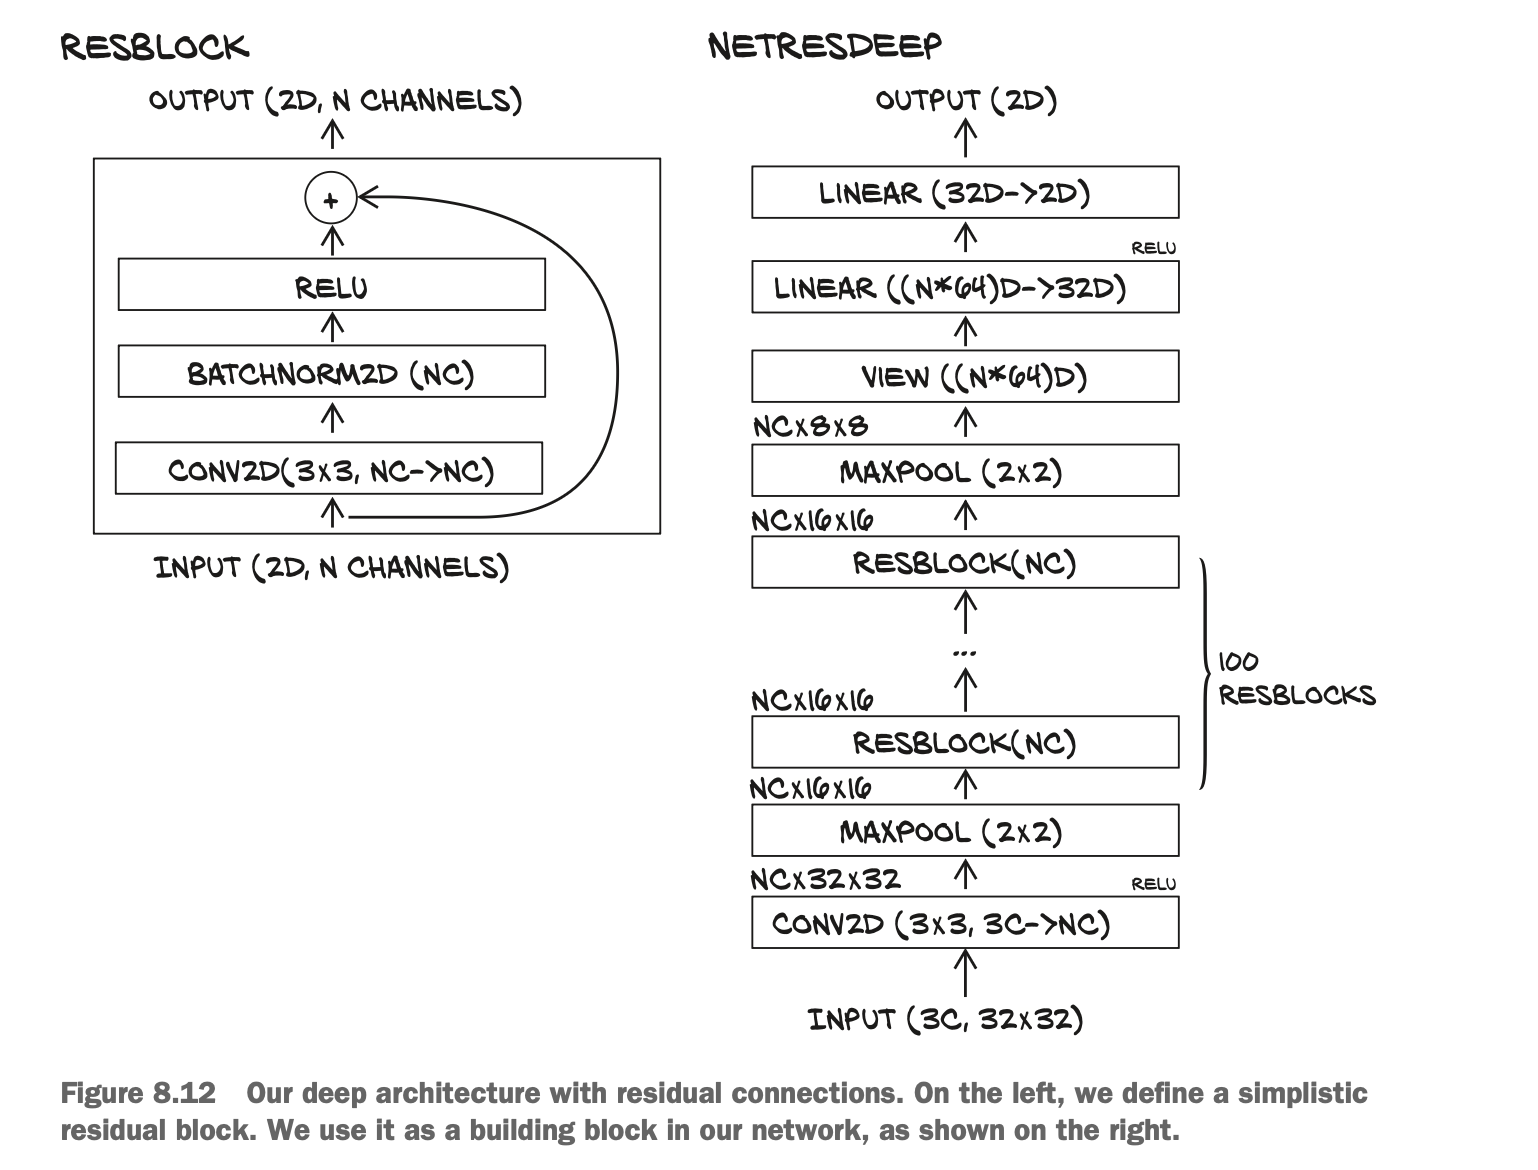

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans, kernel_size = 3,
            padding = 1, bias = Fasle
        )
        self.batch_norm = nn.BatchNorm2d(num_features= n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def foward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
class NetResDeep(nn.Module):
    def __init__(self, n_chans1 = 32, n_blocks = 10):
        super().__init__()
        self.n_chans1 = n_chans1

        self.conv1 = nn.Conv2d(3,n_chans1, kernal_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans = n_chans1)])
        )
        # * 연산자는 파이썬에서 리스트의 요소를 풀어서 전달하는 역할

        self.fc1 = nn.Linear(8 * 8 * n_chans1 , 32)
        self.fc2 = nn.Linear(32,2)
    def forwad(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_chan1s)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out